In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install fasttext

    !git clone https://github.com/MartinKirkegaardDK/KDS_MI.git

    if not has_changed_dir:
        os.chdir('KDS_MI')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from drivers import (
    preprocessing,probe_confidence_intervals,
    steering, create_steering_vectors,
    steering_loss,
    distance_plots,
    create_average_activation_vectors,
    visualising_steering_vectors,
    visualising_activations,
    visualize_probe_results,
    create_bible_data,
    process_bible_data,
    visualize_bible_study,
    probe_confidence_intervals_NEW
)

from pathlib import Path


In [8]:

all_languages = ["nb","is","da","en","sv"]
model_name="downloaded_models/gpt_gptsw3_en_da_is_356m_gbs1024"
#model_name = "EleutherAI/pythia-14m"
model_name = "AI-Sweden-Models/gpt-sw3-356m"

not_target_languages = []
target = "da"



if "download" in model_name:
    model_name_temp = model_name.split("/")[-1]
    for split in model_name.split("_"):
        if (split in all_languages) and (split !=target):
            not_target_languages.append(split)
else:
    
    model_name_temp = model_name.split("/")[-1]
    model_name_temp = model_name_temp.replace("-","_")
    not_target_languages = [lang for lang in all_languages if lang != target]

In [ ]:
#!zip -r zipped.zip results/data/probe_confidence_intervals

## Data preprocessing

Preprocesses the multilingual data, by removing short sentences

In [ ]:
preprocessing.run()

## Analysis of residual stream activations

### PCA of activations

In [ ]:

visualising_activations.run(model_name=model_name)

### Classification probes

In [ ]:
#This takes a long time to run
probe_confidence_intervals.run(
    model_name=model_name,
    reg_lambdas=[0.1, 0.5, 1, 2, 5, 10]
)

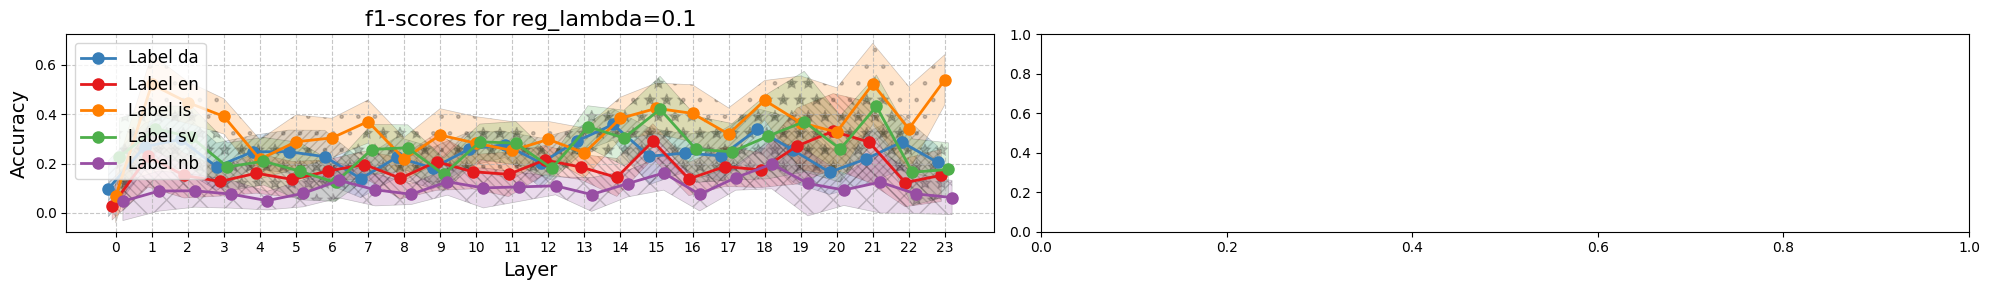

In [6]:
visualize_probe_results.run(
    probe_result_path_by_reg_lambda={
        0.1: f'results/data/probe_confidence_intervals/gpt_sw3_356m_attention:post_reg_lambda_0.1.json',
    },
    model_name= model_name_temp
    
)

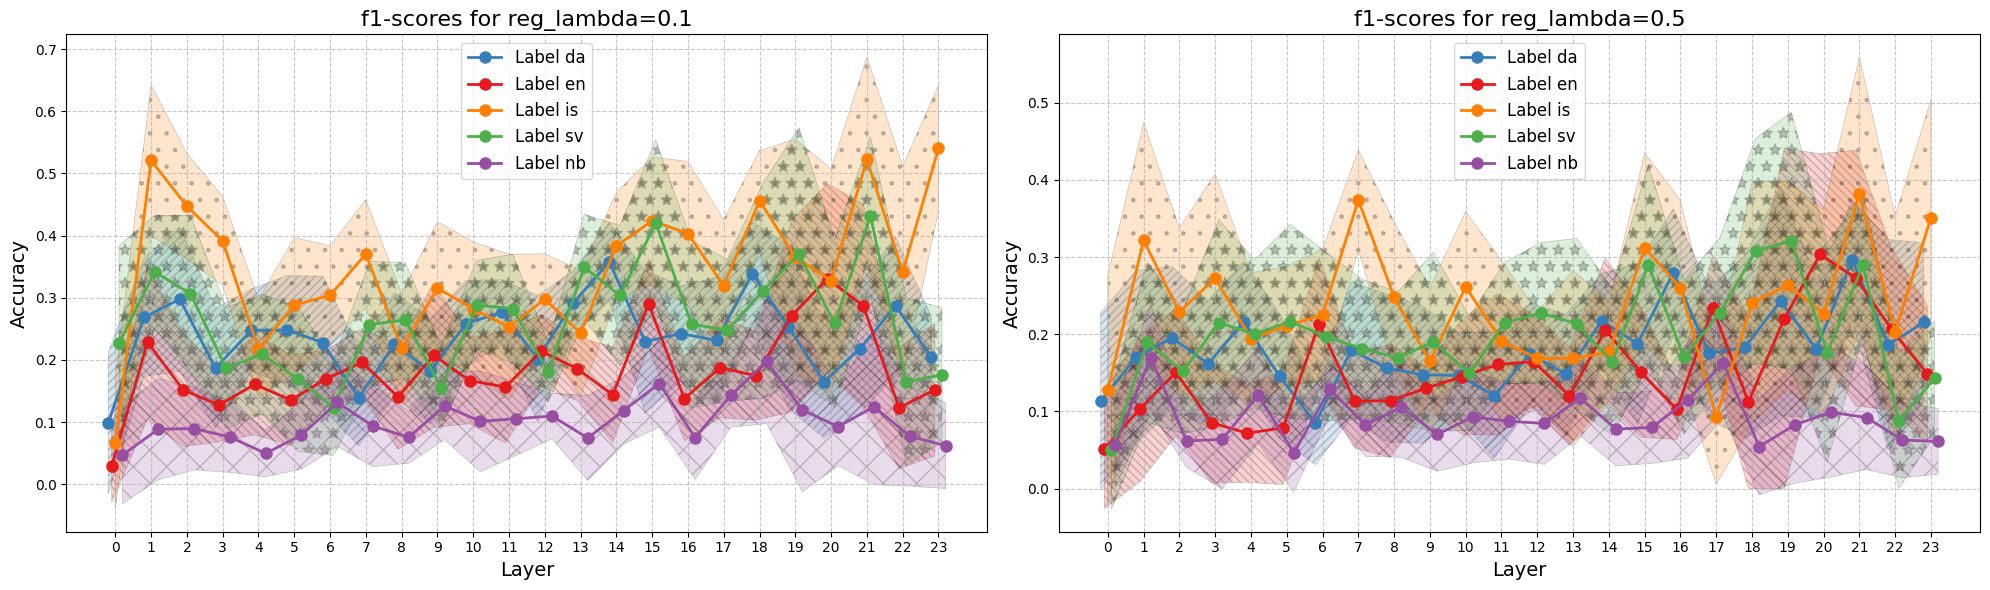

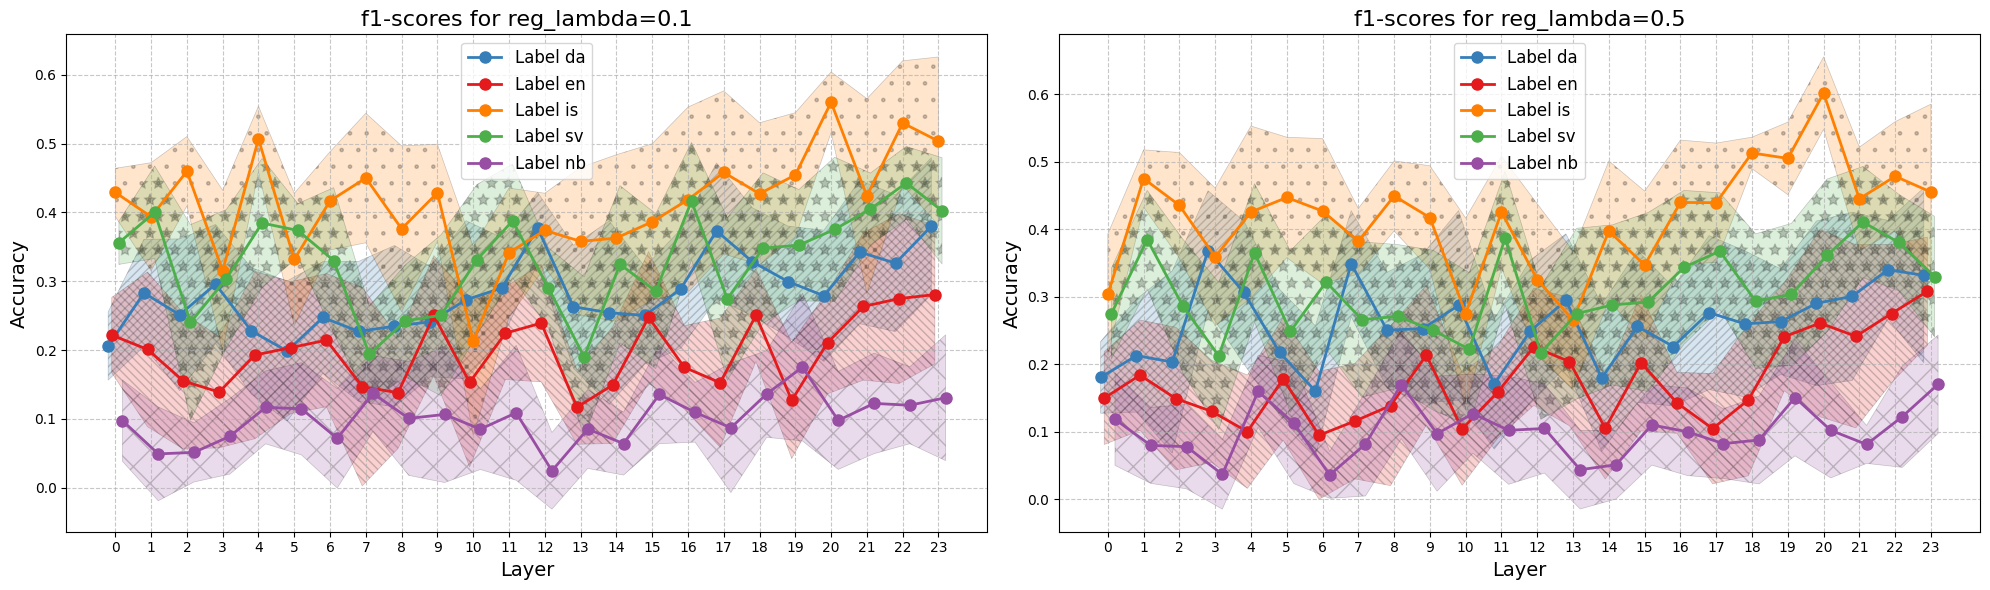

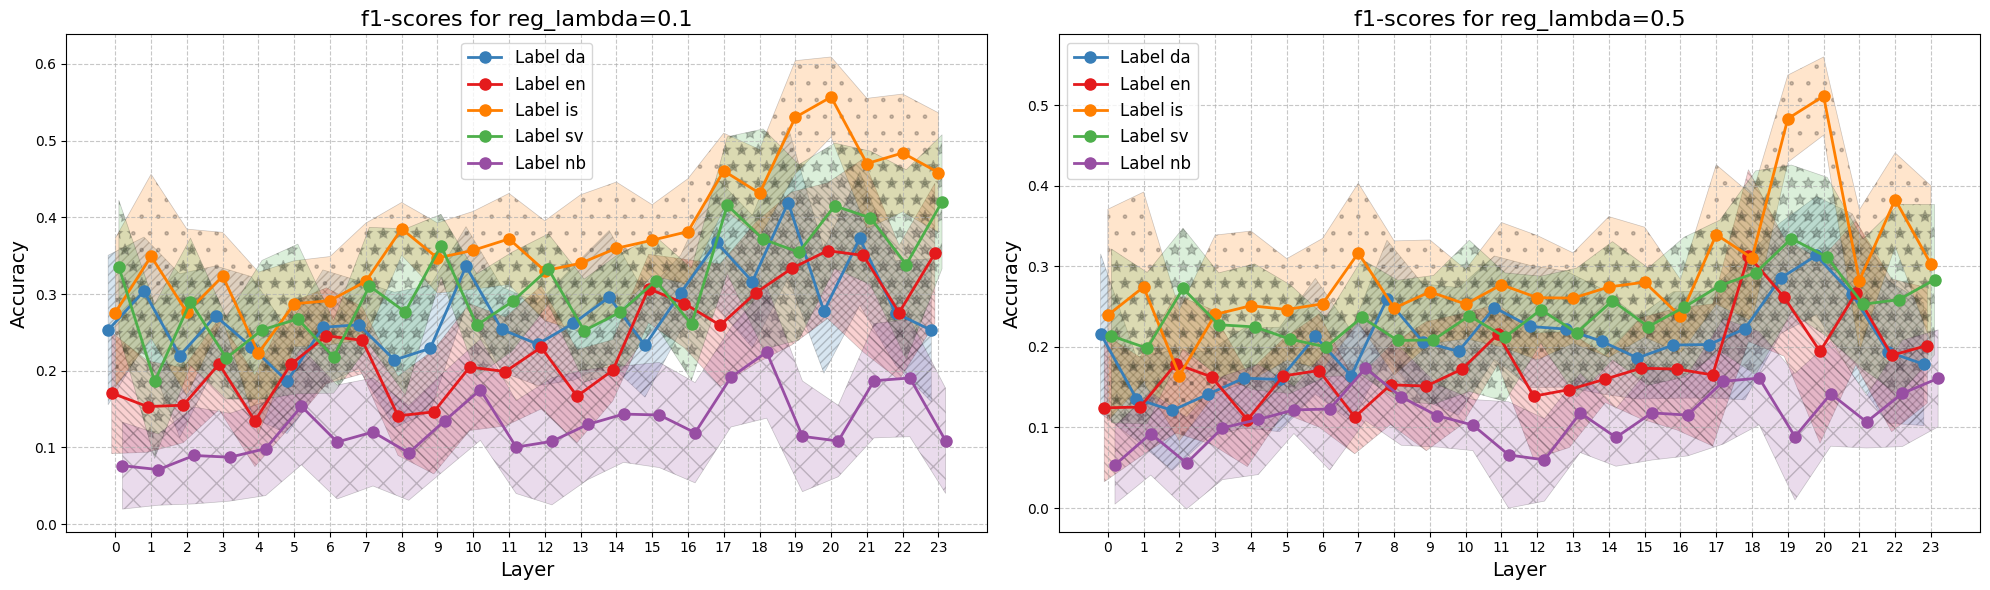

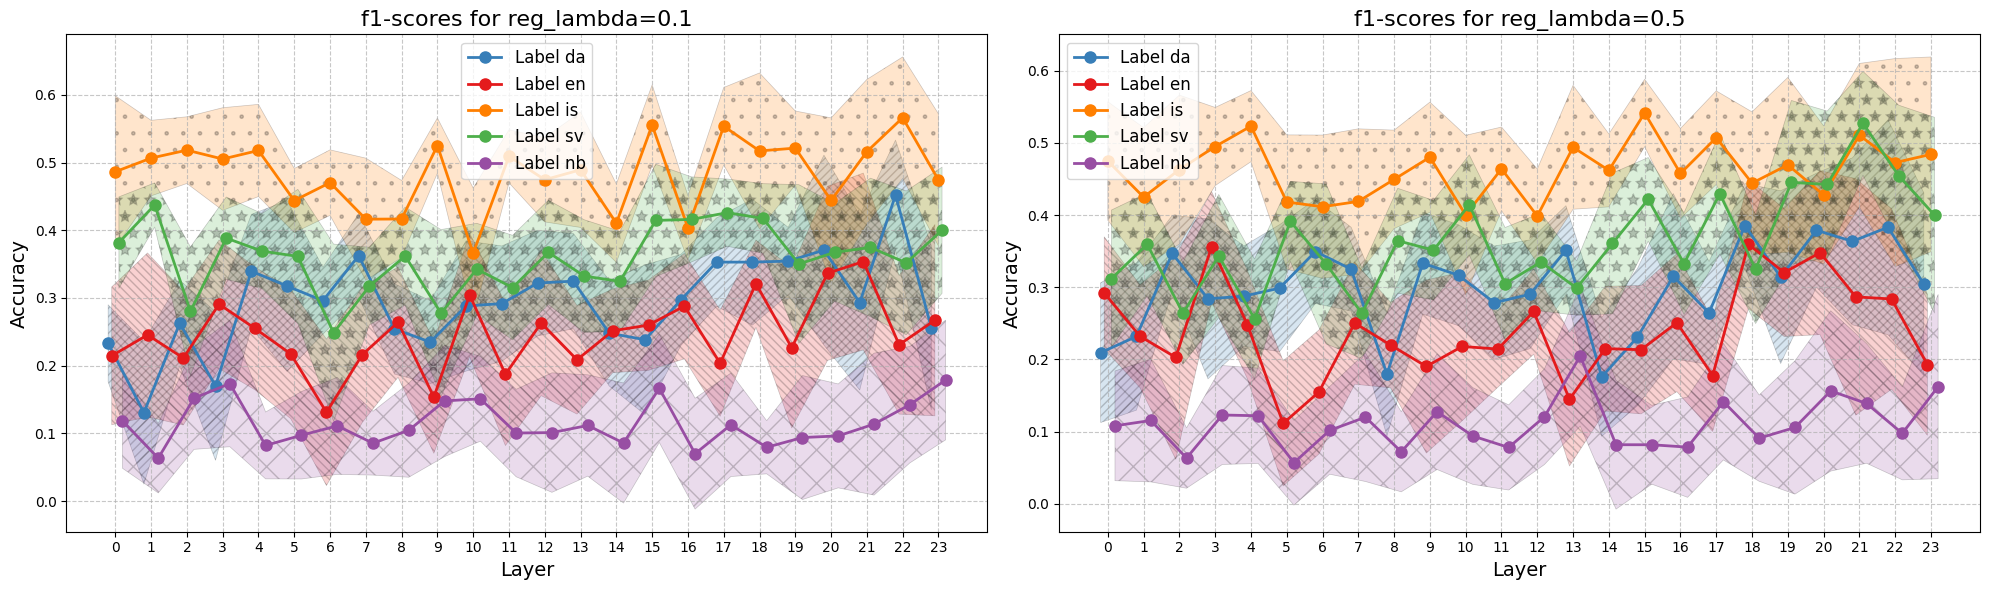

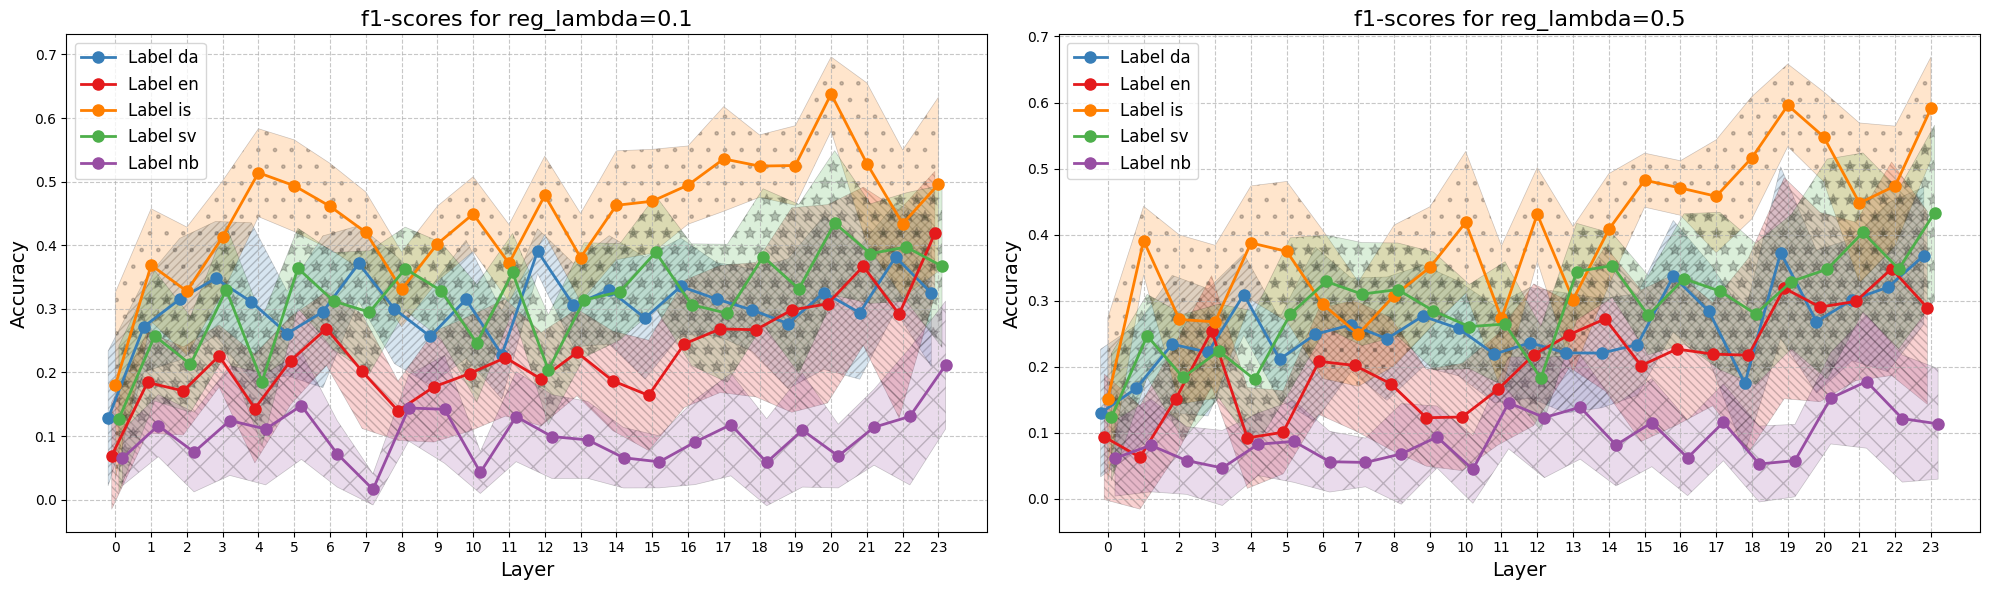

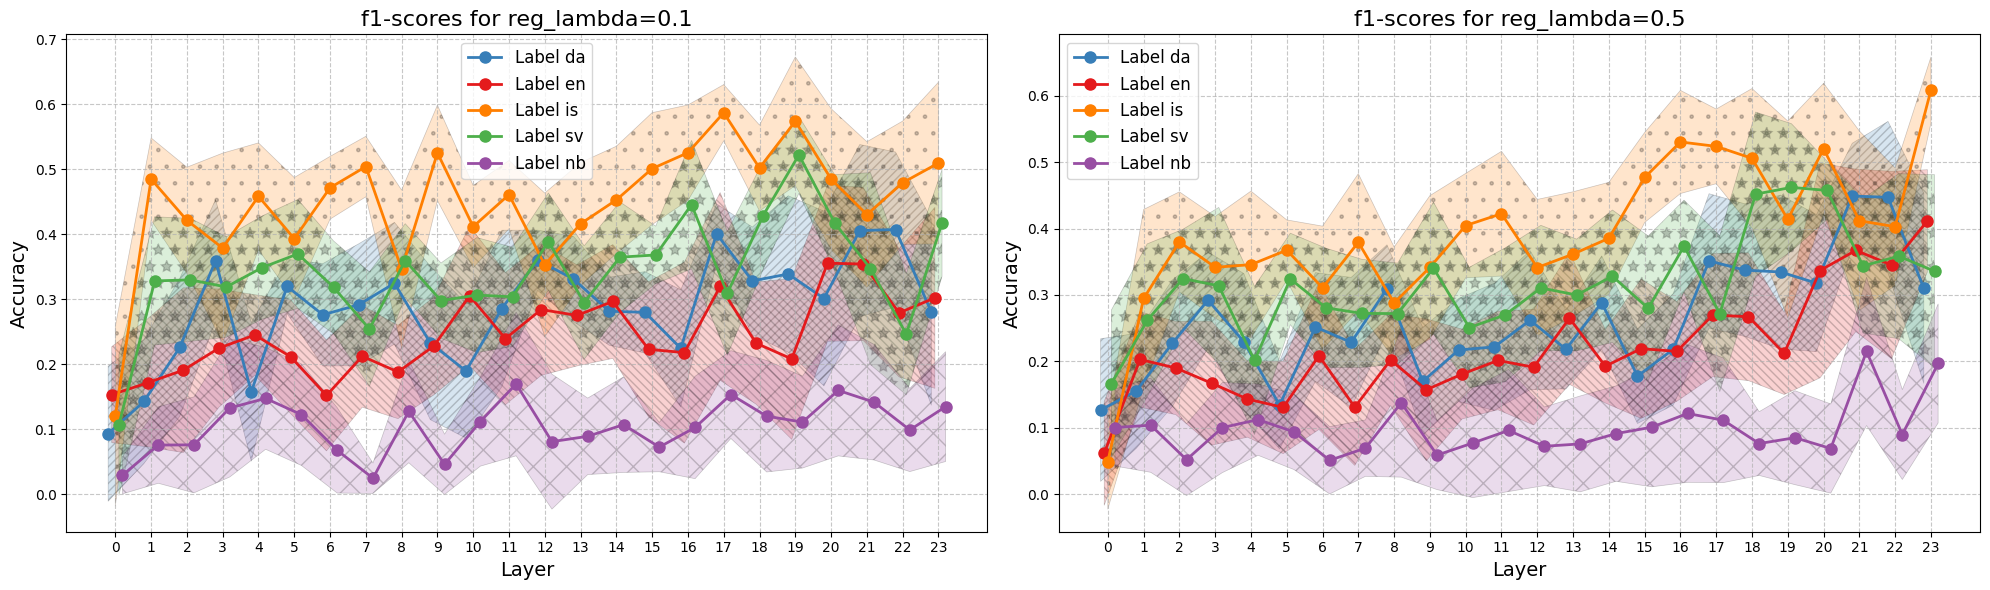

In [12]:
hook_points = ["attention:post","attention:pre","mlp:post","mlp:pre","layernorm_1:pre","layernorm_2:pre"]
for hook_point in hook_points:
    visualize_probe_results.run(
        probe_result_path_by_reg_lambda={
            0.1: f'results/data/probe_confidence_intervals/{model_name_temp}_{hook_point}_reg_lambda_0.1.json',
            0.5: f'results/data/probe_confidence_intervals/{model_name_temp}_{hook_point}_reg_lambda_0.5.json',
        },
        model_name= model_name_temp
        
    )

## Create average activation vectors
these are the "base" steering vectors e.i. the average activations for different layers and languages.
This function generates them and the next block then splits them up for the analysis section.
Additionally, it also saves all the raw activations: raw_activations/\*model_name\*

In [ ]:
model_name_temp

In [ ]:
#create_average_activation_vectors.run(["nb","is","da","en","sv"],model_name= model_name,run_name = model_name_temp)



create_average_activation_vectors.run([target] + not_target_languages,model_name= model_name,run_name = model_name_temp)

## Create steering vector
these are the steering vectors towards a specific language. This is different that

In [ ]:
#AI-Sweden-Models/gpt-sw3-356m

create_steering_vectors.run(
    model_name=model_name_temp,
    target_language=target,
    complement_languages=not_target_languages
)

## plots the distance plots

In [ ]:
#AI-Sweden-Models/gpt-sw3-356m
distance_plots.run(model_name_temp, target,f"average_activation_vectors/{model_name_temp}/","cosine")

## Test steering vectors

In [ ]:
layer = 5

steering_vector_path = f"steering_vectors/{model_name_temp}/combined_steering_vector_layer_{layer}_tensor.pt"

steering.run(
    steering_vector_path=steering_vector_path,
    steering_lambda=5,
    affected_language="en",
    layer=layer,
    model_name=model_name,
    data_folder='data/preprocessed/train'
)

## Measure steering vector loss impact

In [ ]:
#This also takes some time to run
steering_vector_folder = f'steering_vectors/{model_name_temp}'

steering_loss.run(
    steering_vector_folder=steering_vector_folder,
    model_name=model_name,
    model_name_temp=model_name_temp,
    lan1='en',
    lan2='da'
)

## Plot steering vector PCAs

steering_vector_folder = Path('steering_vectors/')

visualising_steering_vectors.run(
    steering_vector_paths_by_language={
        'en': lambda layer: steering_vector_folder / f'EN/combined_steering_vector_layer_{layer}_tensor.pt',
        'da': lambda layer: steering_vector_folder / f'DA/combined_steering_vector_layer_{layer}_tensor.pt',
        'sv': lambda layer: steering_vector_folder / f'SV/combined_steering_vector_layer_{layer}_tensor.pt',
        'nb': lambda layer: steering_vector_folder / f'NB/combined_steering_vector_layer_{layer}_tensor.pt',
        'is': lambda layer: steering_vector_folder / f'IS/combined_steering_vector_layer_{layer}_tensor.pt'
    },
    hidden_layers=24
)

In [ ]:
steering_vector_folder = Path('steering_vectors/')

visualising_steering_vectors.run(
    steering_vector_paths_by_language={
        'en': lambda layer: steering_vector_folder / f'EN/combined_steering_vector_layer_{layer}_tensor.pt',
        'da': lambda layer: steering_vector_folder / f'DA/combined_steering_vector_layer_{layer}_tensor.pt',
    },
    hidden_layers=24
)

## Bible study

In [ ]:
steering_vector_path = f"steering_vectors/{model_name_temp}/"
model_name = model_name
language1 = "da"
langauge2 = "en"
start_verse = 3
end_verse = 1000
lambda_search_space = [2,5,10,15]

create_bible_data.run(model_name,language1, steering_vector_path, lambda_search_space, start_verse,end_verse)


In [ ]:
path = "results/data/steering_data_bible/"
language_label = "__label__dan"
process_bible_data.run(path, language_label)

In [ ]:
visualize_bible_study.run(
    file_path='results/data/steering_data_bible/bible_data_combined.csv'
)

In [ ]:
#save the models with steering vector attached

In [ ]:
reg_lambdas = [0.1, 0.5, 1, 2, 5, 10]
probe_confidence_intervals_NEW.idk(model_name, model_name_temp, reg_lambdas)

Load model
found device: cpu
Load data
Extract activations


  2%|▏         | 3/130 [00:01<01:18,  1.62it/s]


{0: <refactor.utils.data.ActivationDataset object at 0x30f457770>, 1: <refactor.utils.data.ActivationDataset object at 0x3137555b0>, 2: <refactor.utils.data.ActivationDataset object at 0x3097780e0>, 3: <refactor.utils.data.ActivationDataset object at 0x313f36870>, 4: <refactor.utils.data.ActivationDataset object at 0x313f355e0>, 5: <refactor.utils.data.ActivationDataset object at 0x313f34b60>} layernorm_1:pre hi
{0: <refactor.utils.data.ActivationDataset object at 0x311a3e570>, 1: <refactor.utils.data.ActivationDataset object at 0x313755700>, 2: <refactor.utils.data.ActivationDataset object at 0x30fddd7c0>, 3: <refactor.utils.data.ActivationDataset object at 0x313f36690>, 4: <refactor.utils.data.ActivationDataset object at 0x313f35580>, 5: <refactor.utils.data.ActivationDataset object at 0x313f352e0>} attention:pre hi
{0: <refactor.utils.data.ActivationDataset object at 0x311abd760>, 1: <refactor.utils.data.ActivationDataset object at 0x313756990>, 2: <refactor.utils.data.ActivationDat